##Importing Libraries

In [ ]:
import numpy as np

Importing DeepChem

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem as dc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  17862      0 --:--:-- --:--:-- --:--:-- 17862


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

     |████████████████████████████████| 573kB 8.0MB/s 


In [ ]:
from deepchem.models.layers import GraphConv, GraphGather
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from deepchem.feat.mol_graphs import ConvMol

#Model

In [ ]:
class MyGraphConvModel(tf.keras.Model):

  def __init__(self):
    super(MyGraphConvModel, self).__init__()
    self.gc1 = GraphConv(128, activation_fn=tf.nn.relu)

    self.drop = layers.Dropout(rate=0.2)

    self.gc2 = GraphConv(128, activation_fn=tf.nn.relu)

    self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.relu)

    self.dense1 = layers.Dense(256, activation=tf.nn.relu)

    self.dense2 = layers.Dense(128, activation=tf.nn.relu)

    self.dense3 = layers.Dense(64, activation=tf.nn.relu)

    self.dense4 = layers.Dense(32, activation=tf.nn.relu)

    self.dense5 = layers.Dense(1)

  def call(self, inputs):

    gc1_output = self.gc1(inputs)

    drop_output = self.drop(gc1_output)

    gc2_output = self.gc2([drop_output]+ inputs[1:])  

    readout_output = self.readout([gc2_output] + inputs[1:])  

    dense1_output = self.dense1(readout_output)
 
    dense2_output = self.dense2(dense1_output)

    dense3_output = self.dense3(dense2_output)
    
    dense4_output = self.dense4(dense3_output)

    output = self.dense5(dense4_output)
    return output


#Preparing Data

In [ ]:
def data_generator(dataset, epochs=1):
  for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs,
                                                                   deterministic=True, pad_batches=True)):
    multiConvMol = ConvMol.agglomerate_mols(X_b)
    inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
      inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
    
    y = [y_b]
    weights = [w_b]
    yield (inputs, y, weights)

#Splitting Data

In [ ]:
splitters = ['random', 'scaffold', 'butina']

my_featurizer = dc.feat.ConvMolFeaturizer(use_chirality=True)

tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer=my_featurizer, splitter=splitters[0])
train_dataset, valid_dataset, test_dataset = datasets

batch_size = 64

In [ ]:
len(train_dataset.X)

1210

#Fitting the model 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.L2Loss())
losses = []
model.fit_generator(data_generator(train_dataset, epochs=512), all_losses= losses)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


0.020078825099127635

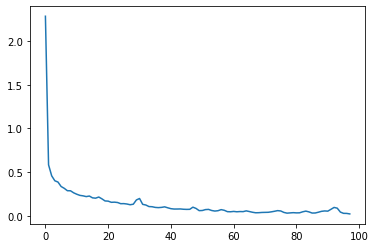

In [ ]:
import matplotlib.pyplot as plt

index = np.arange(len(losses)) 
plt.plot(index, losses)

#Summary

In [ ]:
print(model.model.summary())

Model: "my_graph_conv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_conv (GraphConv)       multiple                  212352    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
graph_conv_1 (GraphConv)     multiple                  346752    
_________________________________________________________________
graph_gather (GraphGather)   multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  65792     
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
dense_2 (Dense)              multiple          

#Metrics

In [ ]:
pearson = dc.metrics.Metric(dc.metrics.pearson_r2_score)
rms = dc.metrics.Metric(dc.metrics.rms_score)
mae = dc.metrics.Metric(dc.metrics.mae_score)

#square of Pearson correlation
print('training set score:', model.evaluate_generator(data_generator(train_dataset), [pearson], transformers))
print('test set score L2:', model.evaluate_generator(data_generator(test_dataset), [pearson], transformers))
print('valid set score L2:', model.evaluate_generator(data_generator(valid_dataset), [pearson], transformers))
# root mean square error
print('test set score rms:', model.evaluate_generator(data_generator(test_dataset), [rms], transformers))
# mean absolute error
print('test set score mae:', model.evaluate_generator(data_generator(test_dataset), [mae], transformers))
# mean squared error
print('test set mse:', model.evaluate_generator(data_generator(test_dataset), [dc.metrics.Metric(dc.metrics.mean_squared_error)], transformers))

training set score: {'pearson_r2_score': 0.9873045340191774}
test set score L2: {'pearson_r2_score': 0.7675296187555141}
valid set score L2: {'pearson_r2_score': 0.7800773913540741}
test set score rms: {'rms_score': 0.6626914724111712}
test set score mae: {'mae_score': 0.5107073594757096}
test set mse: {'mean_squared_error': 0.43915998760648617}


#Build In

In [ ]:
model = dc.models.GraphConvModel(1, mode='regression')
model.fit(train_dataset, nb_epoch=512)

0.012536178742136275

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
rms = dc.metrics.Metric(dc.metrics.rms_score)
print('Training set score:', model.evaluate(train_dataset, [metric], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric], transformers))
print('Test set rms:', model.evaluate(test_dataset, [rms], transformers))

Training set score: {'pearson_r2_score': 0.9884575544418016}
Test set score: {'pearson_r2_score': 0.7372873532752113}
Test set rms: {'rms_score': 0.6857388782302234}
